In [1]:
import multiprocessing as mp
import numpy as np
import time
from PIL import Image, ImageSequence
import glob


T_pred = 16
T_in = 16
vid_l = T_in + T_pred
IMG_H = 125
IMG_W = 125
IMG_CH = 3
DATA_PATH = "/home/ubuntu/data/sim_push/"


def gif_to_np(path):
  def __frame_to_np(frame):
    return np.array(frame.copy().convert("RGB").getdata(),
                    dtype=np.uint8).reshape(frame.size[1],
                                            frame.size[0], 3)

  im = Image.open(path)
  data = np.array(list(map(__frame_to_np, ImageSequence.Iterator(im))))
  return data


def load_path(paths_queue):
  for p in glob.glob(DATA_PATH + "*/*.gif"):
    paths_queue.put(p)
  return


def load_data(paths_queue, data_queue):
    time.sleep(1)
    while not paths_queue.empty():
      data = gif_to_np(paths_queue.get())
      assert(data.shape == (100, IMG_H, IMG_W, IMG_CH))

      for i in range(0, data.shape[0] - (data.shape[0] % vid_l), vid_l):
          assert(data[i:i + vid_l].shape == (vid_l, IMG_H, IMG_W, IMG_CH))
          data_queue.put((data[i:i + T_in], data[i + T_in:i + vid_l]))
      # Get left overs if sufficient size:
      leftover_size = data.shape[0] % vid_l
      if leftover_size >= T_in + 3:
          leftover = data[:-leftover_size]
          leftover_X = leftover[:T_in]
          leftover_Y = np.zeros((T_pred, IMG_H, IMG_W, IMG_CH))
          leftover_Y[:leftover_size - T_in] = leftover[T_in:]
          data_queue.put((leftover_X, leftover_Y))
    return
  
  
def stream_data():
  paths_queue = mp.Queue(maxsize=200)
  path_process = mp.Process(target=load_path, args=(paths_queue,))
  path_process.start()

  data_queue = mp.Queue(maxsize=50)
  processes = [mp.Process(target=load_data, args=(paths_queue, data_queue))
               for i in range(mp.cpu_count())]
  for proc in processes:
      proc.start()

  while True:
    if (data_queue.empty()):
      if any(p.is_alive() for p in processes + [path_process]):
        time.sleep(0.5)
        continue
      else:
        break
    yield data_queue.get()

  for proc in processes + [path_process]:
      proc.join()

      
def batch_stream(batch_s):
    data_stream = stream_data()
    while True:
        batch_X = np.zeros((batch_s, T_in, IMG_H, IMG_W, IMG_CH))
        batch_Y = np.zeros((batch_s, T_pred, IMG_H, IMG_W, IMG_CH))
        for i in range(batch_s):
            try:
                batch_X[i], batch_Y[i] = next(data_stream)
            except StopIteration:
                return
        yield batch_X, batch_Y

In [2]:
import h5py

chunk_size = 64
dtype = np.uint8
chunk_shape = (chunk_size, 16, 125, 125, 3)
maxshape = (None,) + chunk_shape[1:]

gen = stream_data()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import gc
for obj in gc.get_objects():   # Browse through ALL objects
  try:
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            obj.close()
        except:
            pass # Was already closed
  except:
    continue

In [4]:
with h5py.File('25888_more_dataset.h5', 'w') as f:
    X_dset = f.create_dataset('X', shape=chunk_shape, maxshape=maxshape,
                              chunks=chunk_shape, dtype=dtype)
    Y_dset = f.create_dataset('Y', shape=chunk_shape, maxshape=maxshape,
                              chunks=chunk_shape, dtype=dtype)

    row_count = 0
    for x, y in gen:
        if row_count % chunk_size == 0:
          print("Resizing to", row_count + chunk_size)
          X_dset.resize(row_count + chunk_size, axis=0)
          Y_dset.resize(row_count + chunk_size, axis=0)
        X_dset[row_count:] = x
        Y_dset[row_count:] = y
        row_count += 1

Resizing to 32


In [8]:
import h5py
import numpy as np
SAVES_PATH = "/home/ubuntu/saves/"
BATCH = 64

with h5py.File('temp.h5', 'r') as f:
    X = f['X'][:]
    Y = f['Y'][:]


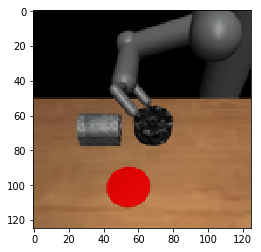

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.array(Y[0][1], dtype=np.uint8))
plt.show()

NameError: name 'paths' is not defined